In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
scotty pippen jr.,24,20.4,111.3,108.6,2.7,28.2,2.53,30.8,3.6,10.8,...,36.0,108.6,10.8,30.1,14.3,8.5,6.6,6.6,19.8,0.083
nicolas batum,36,18.0,109.1,104.9,4.1,8.5,2.71,23.9,3.6,11.5,...,8.2,104.9,11.5,20.2,25.0,6.4,4.7,5.5,16.6,0.093
alperen sengun,22,31.4,114.6,106.6,8.0,24.1,1.86,19.6,9.9,21.4,...,51.7,106.6,21.4,21.8,26.8,10.0,8.7,9.3,31.3,0.143
amir coffey,27,25.5,109.4,110.2,-0.8,6.4,1.76,11.2,1.9,7.1,...,19.3,110.2,7.1,13.1,4.6,9.9,6.9,8.3,25.4,0.091
deni avdija,24,29.0,112.4,115.0,-2.7,18.6,1.41,19.2,4.3,18.3,...,42.3,115.0,18.3,20.7,15.3,11.1,9.1,10.5,27.7,0.063


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,scotty pippen jr.,24,20.4,111.3,108.6,2.7,28.2,2.53,30.8,3.6,...,36.0,108.6,10.8,30.1,14.3,8.5,6.6,6.6,19.8,0.083
1,nicolas batum,36,18.0,109.1,104.9,4.1,8.5,2.71,23.9,3.6,...,8.2,104.9,11.5,20.2,25.0,6.4,4.7,5.5,16.6,0.093
2,alperen sengun,22,31.4,114.6,106.6,8.0,24.1,1.86,19.6,9.9,...,51.7,106.6,21.4,21.8,26.8,10.0,8.7,9.3,31.3,0.143
3,amir coffey,27,25.5,109.4,110.2,-0.8,6.4,1.76,11.2,1.9,...,19.3,110.2,7.1,13.1,4.6,9.9,6.9,8.3,25.4,0.091
4,deni avdija,24,29.0,112.4,115.0,-2.7,18.6,1.41,19.2,4.3,...,42.3,115.0,18.3,20.7,15.3,11.1,9.1,10.5,27.7,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,bruce brown,28,21.1,104.5,116.2,-11.8,13.3,2.00,18.2,4.3,...,30.3,116.2,13.1,23.9,7.4,7.5,6.5,6.0,20.9,0.038
333,kawhi leonard,33,29.8,116.4,108.5,7.9,14.5,1.38,13.0,3.5,...,48.4,108.5,14.0,22.4,15.6,8.6,7.6,9.3,26.6,0.119
334,jarred vanderbilt,25,17.0,113.9,110.5,3.4,10.8,2.14,23.4,10.2,...,29.7,110.5,20.2,36.5,24.0,5.8,4.9,6.5,17.4,0.060
335,dante exum,29,19.1,108.4,117.1,-8.7,21.9,2.63,24.0,1.1,...,40.0,117.1,7.4,21.4,7.7,5.5,5.7,6.1,24.6,0.030


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.4368808682651416
Variance with 3 components: 0.5454640396578202
Variance with 4 components: 0.6430153056464692
Variance with 5 components: 0.6993626163216109
Variance with 6 components: 0.746877961358206
Variance with 7 components: 0.7794365774741041
Variance with 8 components: 0.8094800761086227
Variance with 9 components: 0.8346628965433761
Variance with 10 components: 0.8577314911883942
Variance with 11 components: 0.8789435245439166
Variance with 12 components: 0.8985782589141756
Variance with 13 components: 0.9127326418896834
Variance with 14 components: 0.9262521102321631
Variance with 15 components: 0.9388835965815052
Variance with 16 components: 0.9504279801878801
Variance with 17 components: 0.9601143058068686
Variance with 18 components: 0.9683256549748837
Variance with 19 components: 0.9756559545375528
Variance with 20 components: 0.9816558128465971
Variance with 21 components: 0.9861275498745371
Variance with 22 components: 0.9897055584765827


Variance with 23 components: 0.9929938355563653
Variance with 24 components: 0.9945961204372658
Variance with 25 components: 0.996053044895293
Variance with 26 components: 0.9969659384562028
Variance with 27 components: 0.9977945010530721
Variance with 28 components: 0.9984264300179225
Variance with 29 components: 0.9989227244791505
Variance with 30 components: 0.9993230752679443
Variance with 31 components: 0.9996573560336641
Variance with 32 components: 0.9998711863888164
Variance with 33 components: 0.9999836164823888
Variance with 34 components: 0.9999992787650046
Variance with 35 components: 0.9999999111053426
Variance with 36 components: 0.9999999889526148
Variance with 37 components: 0.9999999968109067
Variance with 38 components: 0.9999999992658126
Variance with 39 components: 1.0000000000000004
Variance with 40 components: 1.0000000000000004
Variance with 41 components: 1.0000000000000004


This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

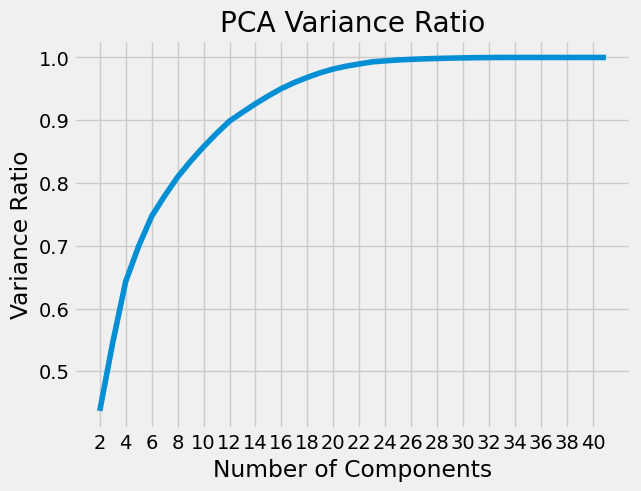

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.08583171e-01 9.75512660e-02 5.63473107e-02 4.75153450e-02
 3.25586161e-02 3.00434986e-02 2.51828204e-02 2.30685946e-02
 2.12120334e-02 1.96347344e-02 1.41543830e-02 1.35194683e-02
 1.26314863e-02 1.15443836e-02 9.68632562e-03 8.21134917e-03
 7.33029956e-03 5.99985831e-03 4.47173703e-03 3.57800860e-03
 3.28827708e-03 1.60228488e-03 1.45692446e-03 9.12893561e-04
 8.28562597e-04 6.31928965e-04 4.96294461e-04 4.00350789e-04
 3.34280766e-04 2.13830355e-04 1.12430094e-04 1.56622826e-05
 6.32340338e-07 7.78472722e-08 7.85829191e-09 2.45490595e-09
 7.34187822e-10 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

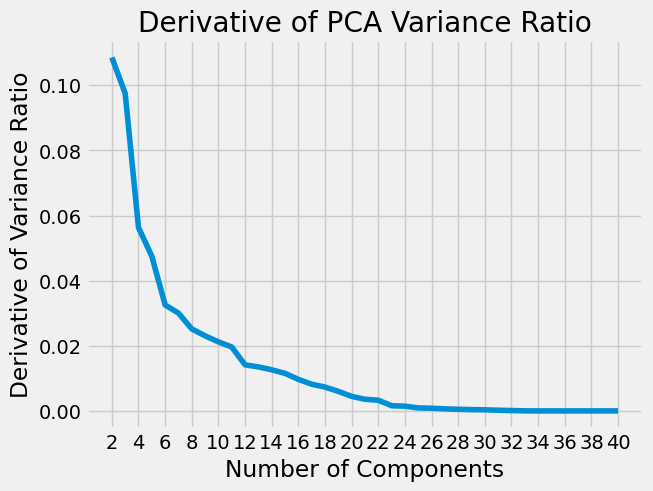

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.22266989 0.21421098 0.10858317 0.09755127 0.05634731 0.04751535
 0.03255862 0.0300435  0.02518282 0.02306859 0.02121203 0.01963473
 0.01415438 0.01351947 0.01263149 0.01154438]
0.9504279801878801


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.1592565253106961
Silhouette Score with 3 clusters: 0.19185541997922867
Silhouette Score with 4 clusters: 0.15139820002965285
Silhouette Score with 5 clusters: 0.13615918206601557
Silhouette Score with 6 clusters: 0.13080228759943857
Silhouette Score with 7 clusters: 0.129200197372959
Silhouette Score with 8 clusters: 0.12509716945156915
Silhouette Score with 9 clusters: 0.11583672487399724
Silhouette Score with 10 clusters: 0.11510167210587656
Silhouette Score with 11 clusters: 0.10845401710524327
Silhouette Score with 12 clusters: 0.11095444899718838
Silhouette Score with 13 clusters: 0.09665620751498995
Silhouette Score with 14 clusters: 0.10289540081297376
Silhouette Score with 15 clusters: 0.0887575667935368
Silhouette Score with 16 clusters: 0.08522730317894407
Silhouette Score with 17 clusters: 0.08761991052279523
Silhouette Score with 18 clusters: 0.09039217008504803
Silhouette Score with 19 clusters: 0.08802790194335432
Silhouette Score with 

Silhouette Score with 24 clusters: 0.08671440772260278
Silhouette Score with 25 clusters: 0.09047190261306068
Silhouette Score with 26 clusters: 0.08868752466976704
Silhouette Score with 27 clusters: 0.08478258586938982
Silhouette Score with 28 clusters: 0.08486705678413968
Silhouette Score with 29 clusters: 0.08031809456344968
Silhouette Score with 30 clusters: 0.08398743746364638
Silhouette Score with 31 clusters: 0.08348880469636002


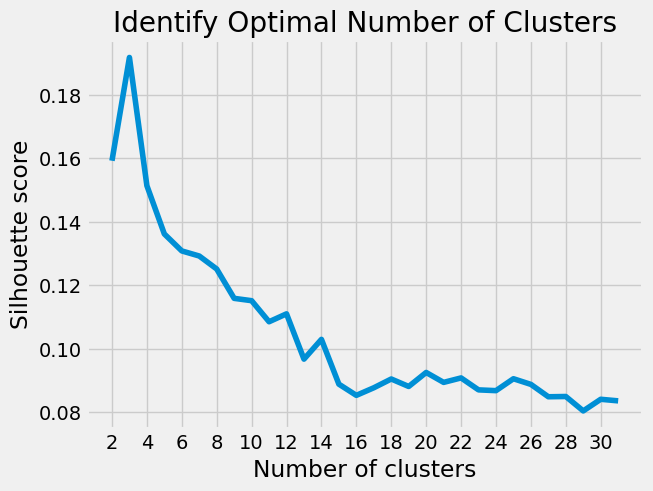

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = 0.03877388959882133
for n_cluseter = 4, improvement = -0.05006185891704651
for n_cluseter = 5, improvement = -0.017957795946426103
for n_cluseter = 6, improvement = -0.006201251845668443
for n_cluseter = 7, improvement = -0.001843182746138261
for n_cluseter = 8, improvement = -0.004711792433819806
for n_cluseter = 9, improvement = -0.010584540653236996
for n_cluseter = 10, improvement = -0.00083135410483548
for n_cluseter = 11, improvement = -0.007512337622394671
for n_cluseter = 12, improvement = 0.0028046022750576327
for n_cluseter = 13, improvement = -0.016082687176231403
for n_cluseter = 14, improvement = 0.006906776080035315
for n_cluseter = 15, improvement = -0.015759404234744867
for n_cluseter = 16, improvement = -0.0038741211843815737
for n_cluseter = 17, improvement = 0.0026155211586066374
for n_cluseter = 18, improvement = 0.00303849195551964
for n_cluseter = 19, improvement = -0.002599217007525967
for n_cluseter = 20, improvement = 0.0048459

C:\conda_tmp\ipykernel_20052\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


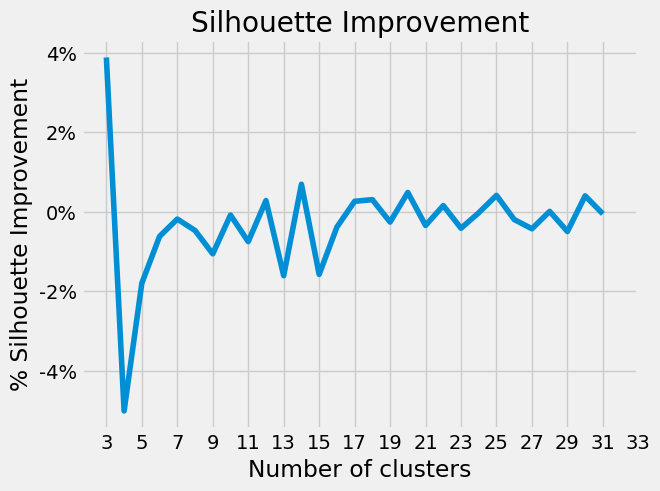

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,scotty pippen jr.,4
1,nicolas batum,6
2,alperen sengun,12
3,amir coffey,1
4,deni avdija,9


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()